# Building a mock catalogue for S2 star

In this notebook we will a produce mock catalogue for the S2 star in the Galactic Centre, considering a relativistic orbital model in a Schwarzschild spacetime (assuming that SgrA* is a non rotating black hole described by General Relativity) and we will produce simulated astrometric positions and radial velocity measurements as could be potentially measured by the GRAVITY instrument at VLT.

### Utilities

First, let's define a few important and useful quantities.

- Importing packages:

In [1]:
import pygro
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from datetime import datetime, timedelta
import time


%matplotlib inline

- Fundamental constants:

In [2]:
# Newton's constant
G_N = 6.67430e-11 #N*m^2/kg^2

# Speed of light in vacuum
c = 2.99792458e+8 #m/s

# Seconds in a Julian Year
yr_s = 3600*24*365.25 # s

# Mass of the sun
Msun = 1.98847e+30 #Kg

#Astronomical distances
kpc = 3.086e+19 #m
AU = 149597870691 #m  

- Orbital parameters for S2 as measured by the GRAVITY collaboration

In [3]:
M_bh = 4.261 # 10^6 Msun
D = 8.2467 # kpc
T = 16.0455 # yr
Tp =  2018.379 # yr
a = 0.125058 # as
e = 0.884649 
inc = np.deg2rad(134.567) #rad 
Omega = np.deg2rad(228.171) # rad
omega = np.deg2rad(66.263) # rad

- Defining Metric and GeodesicEngine objects ib PyGRO on a Schwarzschild spacetime in isotropic coordinates

In [4]:
metric = pygro.Metric()

metric.load_metric("metrics/SchwarzschildIsotropic.metric", G_N = G_N*Msun/AU**3, c = c/AU, M = M_bh*1e+6)

Loading Schwarszschild Isotropic
The metric_engine has been initialized.


In [5]:
geo_engine = pygro.GeodesicEngine(metric)

Linking Schwarszschild Isotropic to the Geodesic Engine
Metric linking complete.


### Calculating the orbit of S2

In [6]:
# Transforming the distance of SgrA* and the semi-major axis in AU
D_s = D*kpc/AU
a_sma = a*np.pi/3600/180*D_s

#Transforming thethe period in seconds
T_s = T*yr_s

# Defining the initial time which we assume to be the last apocentre passage:
# this is because the orbital parameter given by the Gravity Collaboration
# refer to the oscualting ellipse at the time of the last apocentre passage
t0 = Tp-T/2

# Thiele - Innes elements for the projection from BH reference frame to the observer's one
A = np.cos(omega)*np.cos(Omega)-np.sin(omega)*np.sin(Omega)*np.cos(inc)
B = np.cos(omega)*np.sin(Omega)+np.sin(omega)*np.cos(Omega)*np.cos(inc)
C = -np.sin(omega)*np.sin(inc)
F = -np.sin(omega)*np.cos(Omega)-np.cos(omega)*np.sin(Omega)*np.cos(inc)
G = -np.sin(omega)*np.sin(Omega)+np.cos(omega)*np.cos(Omega)*np.cos(inc)
H = -np.cos(omega)*np.sin(inc)

# Initial conditions from Keplerian elements in celestial coordiantes at apocentre
r0 = a_sma*(1+e)
phi0 = np.pi

v0 = 2*np.pi/T_s*a_sma**2/(a_sma*(1+e))*np.sqrt(1-e**2)*AU/c
vr0 = 0
vphi0 = v0/r0

# Definition of the Geodesic objects.
geo = pygro.Geodesic("time-like", geo_engine, verbose = False)
geo.set_starting_point(0, r0, np.pi/2, phi0)
u0 = -geo.get_initial_u0(vr0, 0, vphi0)
geo.initial_u = [u0, vr0, 0, vphi0]


#### Numerical integration ####
# 
# Parameters of the integration:
#
# - We want to simulate 4 entire orbits of the stars, hence we fix at 4*T_s the time for the integration
#
# - Since in the most "interesting" portions of the orbit we want to simulate night by night observations
#   we fix as initial and maximum step of integration one day = 3600*24
#
# - We use machine precision for both the accuracy and the precision of the integration
#
################################


geo_engine.integrate(geo, tauf = 4*T_s*c/AU, initial_step = 3600*24*c/AU, PrecisionGoal = 8, AccuracyGoal = 8, direction = "fw", hmax = 3600*24*c/AU, verbose = "True")


# The Geodesic object now stores the integrated orbit as follows:
#
# geo.x[:,0] = Array of coordinate time in seconds
# geo.x[:,1] = Array of radial isotropic coordinates in AU
# geo.x[:,2] = Array of angular colatitude angle coordinates
# geo.x[:,3] = Array of angular azimuthal angle coordinate
# 
# geo.tau = Array of proper times of the star in units of:
#                   
#                   Speed of light * Time unit (where the speed of light is measured in AU/s)
#
#           this is why we multiplied by c/AU the final time, initial and maxium step of integration
#           which in PyGRO is performed in terms of proper time           
#
# We need to perform projection and conversion back to celestial coordinates


t = geo.x[:,0]/yr_s+t0               #   Converting time in years and making the scale start at apocentre

x = geo.x[:,1]*np.cos(geo.x[:,3])    #   Cartesian like coordinates of the star in the BH reference frame
y = geo.x[:,1]*np.sin(geo.x[:,3])    #
                          
RA = (B*x+G*y)/D_s*180/np.pi*3600    #   Right ascension of the star in units of arcsec in the observer reference frame
Dec = (A*x+F*y)/D_s*180/np.pi*3600   #   Declination of the star in units of arcsec in the observer reference frame
z = (C*x+H*y)                        #   Distance in AU of the star from the BH along the line of sight


#   Conversion of velocity vector from spherical coordinates to cartesian ones

vx = np.cos(geo.x[:,3])*geo.u[:,1]-geo.x[:,1]*np.sin(geo.x[:,3])*geo.u[:,3]
vy = np.sin(geo.x[:,3])*geo.u[:,1]+geo.x[:,1]*np.cos(geo.x[:,3])*geo.u[:,3]

#   Projeciton of the velocities from the BH reference frame to that of the observer

vRA = (B*vx+G*vy)*c
vDec = (A*vx+F*vy)*c
vLOS = -(C*vx+H*vy)*c      

# The quantity vLOS is the kinematic velocity along the line of sight of the star, in order to obtain from it
# the velocity that would be observed by a distant observer through spectroscopic measurements,
# one has to take into account the redshift due to both special relativistic Doppler effect
# and the gravitational redshift due to the vicinity of the massive BH


VR = []

for i in range(len(vLOS)):

    VR.append(1/(np.sqrt(-metric.g_f(geo.x[i])[0,0]*(AU/c)**2))*(1+vLOS[i]/c)*1/np.sqrt(1-(vx[i]**2+vy[i]**2))-1)

VR = np.array(VR)*c/1000 # conversion in km/s

# Finally let's build interpolating function of the integrated orbit,
# so that mock measurements can be built for any date within the integration range

RA_int = interp1d(t, RA)
Dec_int = interp1d(t, Dec)
z_int = interp1d(t, z)
VR_int = interp1d(t, VR)

Integrating...


Integration time = 7.675625624999995 s


### Building the dataset

We now need to build a credible dataset that could mimic an observational campaign from the GRAVITY instrument.
We assume, as already happened for the pericentre passage in 2018, that the sampling of the observation is more dense around pericenter and more rarefied elsewhere. We thus assume that the GRAVITY instruments performs:

- One observation per day in two weeks centered on the pericentre
- One observation every two nights in a month centered on the pericentre
- One observation per week in the two months centered on the pericentre
- One observation per month in the rest of the year of pericentre passage
- Two observations per year in the rest of the years

we thus build an array of observation times in the following way:

In [7]:
t_i = 2018
t_day = 1/365.25
dt = t_day*1

# We define a new interpolating function which returns the number of days to/from the pericentre passage for each day

days_from_pericentre = interp1d(t, abs(((t-t0)%T-T/2))*365.25)

We now, starting from 2018.00, test each day of the years within the 4 periods of the S2 star and we include it in an array if it satisfies the criteria defined above to plan the observational campaign

In [8]:
t_obs = []

t_test = t_i

while t_test < max(t):
    
    t_test += t_day
    
    print(t_test, end = "\r")
    
    if t_test < max(t):
        
        if days_from_pericentre(t_test) <= 7:
            dt = t_day
        elif days_from_pericentre(t_test) <= 15:
            dt = t_day*2
        elif days_from_pericentre(t_test) <= 30:
            dt = t_day*7
        elif days_from_pericentre(t_test) <= 365:
            dt = t_day*30
        else:
            dt = t_day*180

        if t_test - t_i >= dt:
            t_i += dt

            if t_i < max(t):
                t_obs.append(t_i)

The above defined array <code> t_obs </code> contains the decimal dates of observations. These are not coincident with the date of emission due to the Rømer delay (since we are only interested in the modulation produced by the Rømer delay on the arrival times, we can assume that the travel time of a photon from SgrA* to Earth is null, as it would only represent an additional constant on all the measurements). We appply then the relation

$$
t_{\rm em} -t_{\rm obs} = \frac{z_{\rm obs}(t_{\rm obs})}{c}
$$

which, after all the unit conversions becomes

In [9]:
t_em = t_obs+z_int(t_obs)*AU/c/yr_s

giving:

Text(0, 0.5, 'Days of delay')

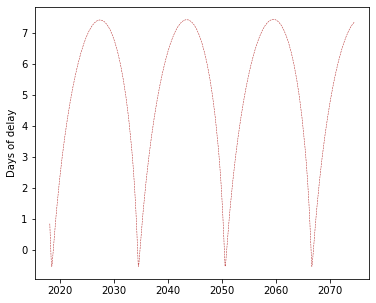

In [10]:
fig, ax = plt.subplots(figsize = (6,5))

ax.plot(t_em, (t_em-t_obs)*365.25, color = "firebrick", linestyle = "--", linewidth = 0.5)
ax.set_ylabel("Days of delay")

which correspond to roughly +7.5 days at apocentre and about -0.5 days at pericente.

Now we can find the astrometric positions observed at the time of observation as the ones of the star at the time of emission (we are assuming that astrometric and spectroscopic observation happen in the same nights)

Lets convert the decimal times to datetime objects

In [11]:
def convert_partial_year(number):

    year = int(number)
    d = timedelta(days=(number - year)*365)
    day_one = datetime(year,1,1)
    date = d + day_one
    return date

t_dates = [convert_partial_year(t_obs_i) for t_obs_i in t_obs]

### Mock observations

In [12]:
RA_points = RA_int(t_em)
Dec_points = Dec_int(t_em)
VR_points = VR_int(t_em)

Finally, measurement uncertainties are considered by adding gaussian noise with a deviation of $10\mu as$ on each of the astrometric positions and 10 km/s on radial velocities

In [13]:
N = len(RA_points)

err_A = 1e-5
err_VR = 10

RA_points += np.random.randn(N)*err_A
Dec_points += np.random.randn(N)*err_A
VR_points += np.random.randn(N)*err_VR

#### Final dataset

In [14]:
mock_catalogue = pd.DataFrame(data = {"t": t_obs, "t_date": t_dates, "RA": RA_points, "Dec": Dec_points, "VR": VR_points})
mock_catalogue["t_date"] = mock_catalogue["t_date"].dt.strftime("%Y-%d-%m")


In [15]:
mock_catalogue

,t,t_date,RA,Dec,VR
0,2018.082136,2018-30-01,-0.032344,-0.005679,3305.149819
1,2018.164271,2018-01-03,-0.026324,-0.009602,3674.025965
2,2018.246407,2018-31-03,-0.018279,-0.012723,4040.137639
3,2018.265572,2018-07-04,-0.015993,-0.013199,4107.089959
4,2018.284736,2018-14-04,-0.013512,-0.013540,4093.613599
...,...,...,...,...,...
299,2072.422998,2072-03-06,-0.009625,0.175983,-412.508223
300,2072.915811,2072-30-11,-0.015324,0.177428,-334.272272
301,2073.408624,2073-30-05,-0.020910,0.177737,-263.691298
302,2073.901437,2073-26-11,-0.026386,0.177065,-219.840365


### Plotting the dataset

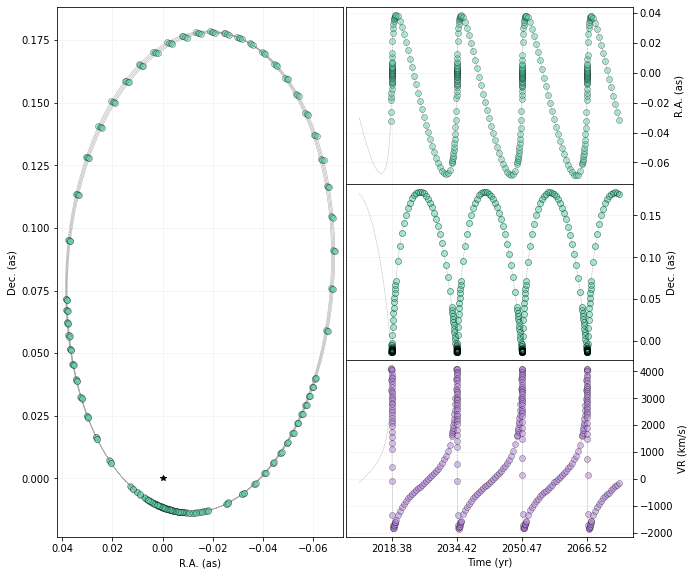

In [16]:
fig, ax = plt.subplots(figsize = (10,8))

# Full orbit plot

ax1 = plt.subplot(121)

ax1.plot(RA, Dec, color = "#ababab", linestyle = "-", linewidth = 0.5)
ax1.plot(RA_points, Dec_points, "o", color = "#60d1ab", markeredgewidth = 0.5, alpha = 0.5, markeredgecolor = "k")
ax1.plot(0, 0, "*", color = "k")

ax1.axis('equal')
ax1.invert_xaxis()

ax1.grid(color = "#f3f3f3")

# VR plot

ax4 = plt.subplot(326)

ax4.plot(t, VR, linestyle = "--", color = "#ababab", linewidth = 0.5)
ax4.plot(t_obs, VR_points, "o", color = "#b481db", markeredgewidth = 0.5, alpha = 0.5, markeredgecolor = "k")

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

ax4.grid(color = "#f3f3f3")

ax4.set_xticks([Tp+i*T for i in range(4)])
ax4.set_xticklabels([f"{Tp+i*T:.2f}" for i in range(4)])

ax4.set_zorder(9)

# RA plot

ax2 = plt.subplot(322, sharex = ax4)

ax2.plot(t, RA, linestyle = "--", color = "#ababab", linewidth = 0.5)
ax2.plot(t_obs, RA_points, "o", color = "#60d1ab", markeredgewidth = 0.5, alpha = 0.5, markeredgecolor = "k")

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax2.grid(color = "#f3f3f3")

# Dec plot

ax3 = plt.subplot(324, sharex = ax4)

ax3.plot(t, Dec, linestyle = "--", color = "#ababab", linewidth = 0.5)
ax3.plot(t_obs, Dec_points, "o", color = "#60d1ab", alpha = 0.5)
ax3.plot(t_obs, Dec_points, "o", color = "none", markeredgewidth = 0.5, alpha = 0.5, markeredgecolor = "k")

ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")

ax3.grid(color = "#f3f3f3")


# Adjustments

ax1.set_xlabel("R.A. (as)")
ax1.set_ylabel("Dec. (as)")

ax2.set_ylabel("R.A. (as)")

ax3.set_ylabel("Dec. (as)")

ax4.set_xlabel("Time (yr)")
ax4.set_ylabel("VR (km/s)")

fig.subplots_adjust(wspace = 0.01, hspace = 0, left = 0.1, right = 0.9, top = 0.98, bottom = 0.06)